In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from oma_tracking.oma_clustering import ModeClusterer  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import DatasetGetter, get_scada_subset, get_weather_subset
from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files
from oma_tracking.scouring.scouring import aggregate_time_series

In [13]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2c02'
name_location = 'NW2_C02'

# Data Paths
data_file_name = '_'.join([location, start.strftime("%Y%m%d"), stop.strftime("%Y%m%d")])
data_path = "../../data/nw2/raw/" + data_file_name + ".parquet"
mvbc_path = "../../data/nw2/mvbc_data.parquet"
tracked_frequencies_path = "../../data/nw2/tracked_modes/" + location + ".parquet"
simulations_data_path = "../../data/nw2/simulations/" + location + "/"
simulations_data_path


# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
#simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
#simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
#simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)

In [14]:
import mlflow
models = {}
for mode in tracked_frequencies.columns:
    model_name = 'mpe_' + name_location + '_' + mode + '_normalization'
    stage = 'Staging'
    try:
        models[mode] = \
            mlflow.pyfunc.load_model(
                model_uri=f"models:/{model_name}/{stage}")
    except:
        print('no ' + stage + ' model ' + model_name)

In [1]:
weather_inputs = get_weather_subset(mvbc_data)
scada_inputs = get_scada_subset(data)

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

NameError: name 'get_weather_subset' is not defined

In [ ]:
scada_inputs

In [16]:
predictions = pd.DataFrame(index = inputs.dropna().index)
for mode in models.keys():
    predictions[mode] = models[mode].predict(inputs.dropna())
residuals = prediction_params - predictions
normalized = residuals + tracked_frequencies.mean()

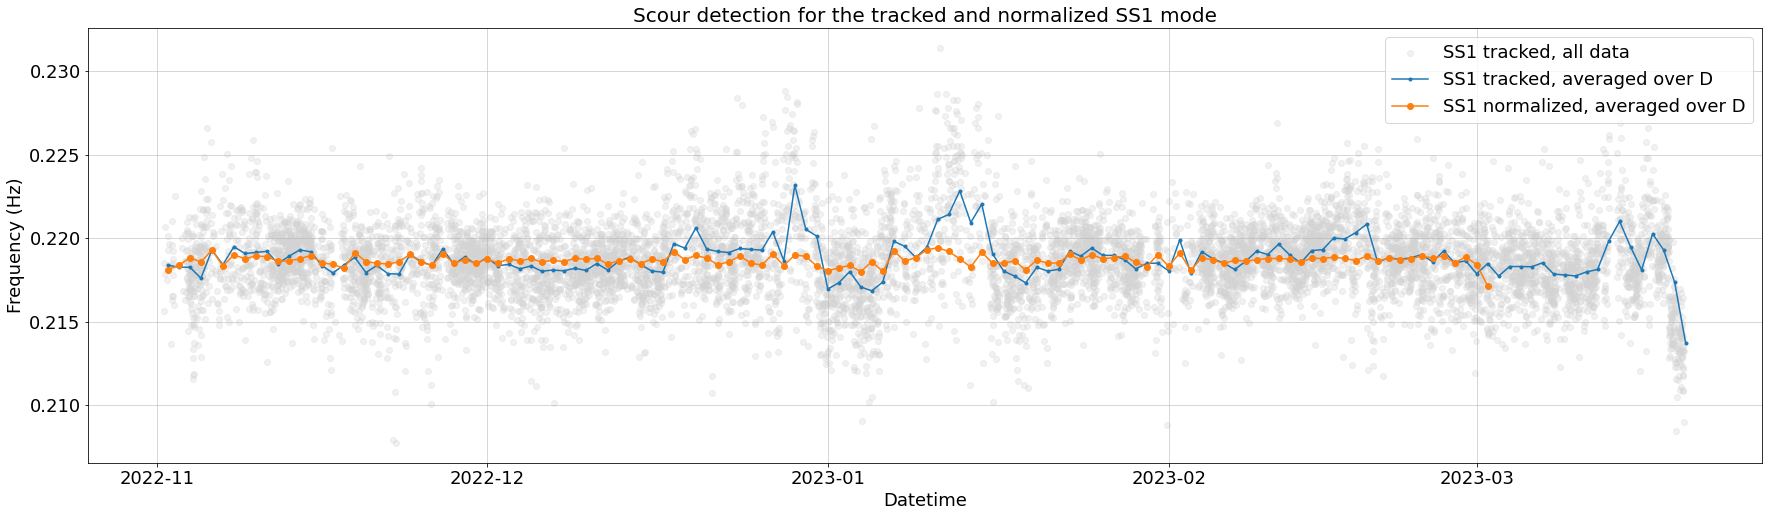

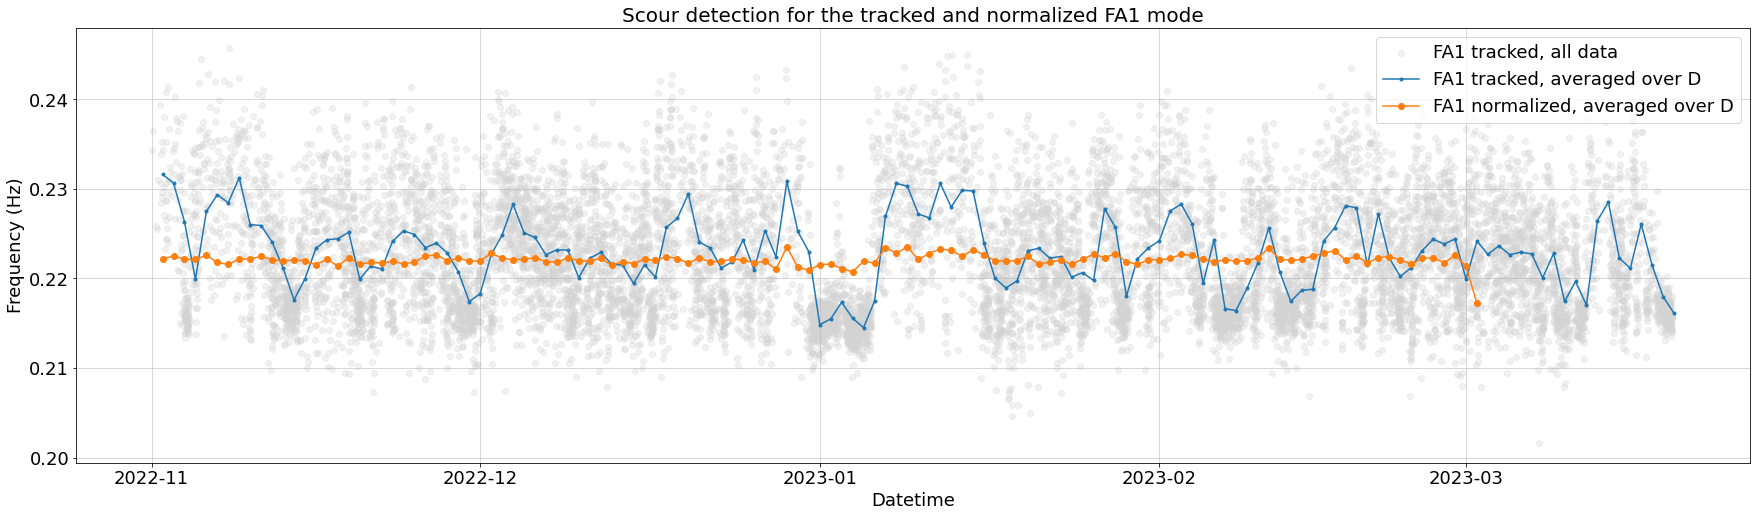

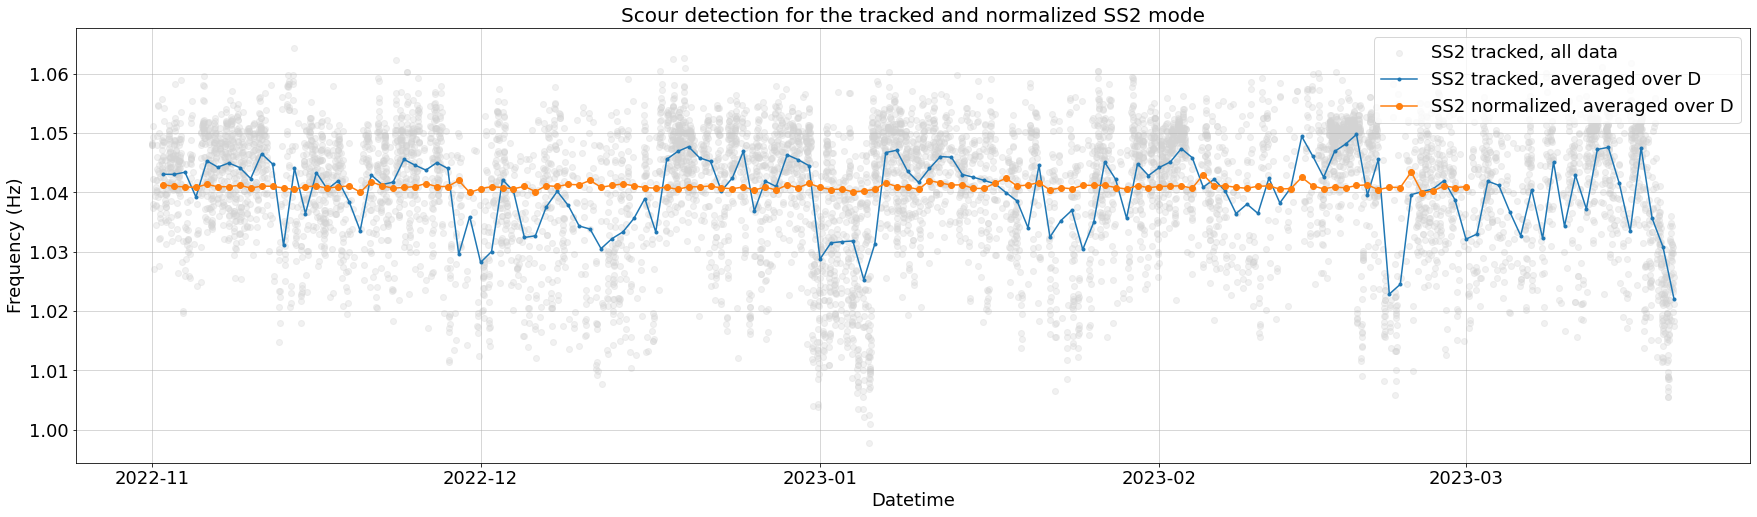

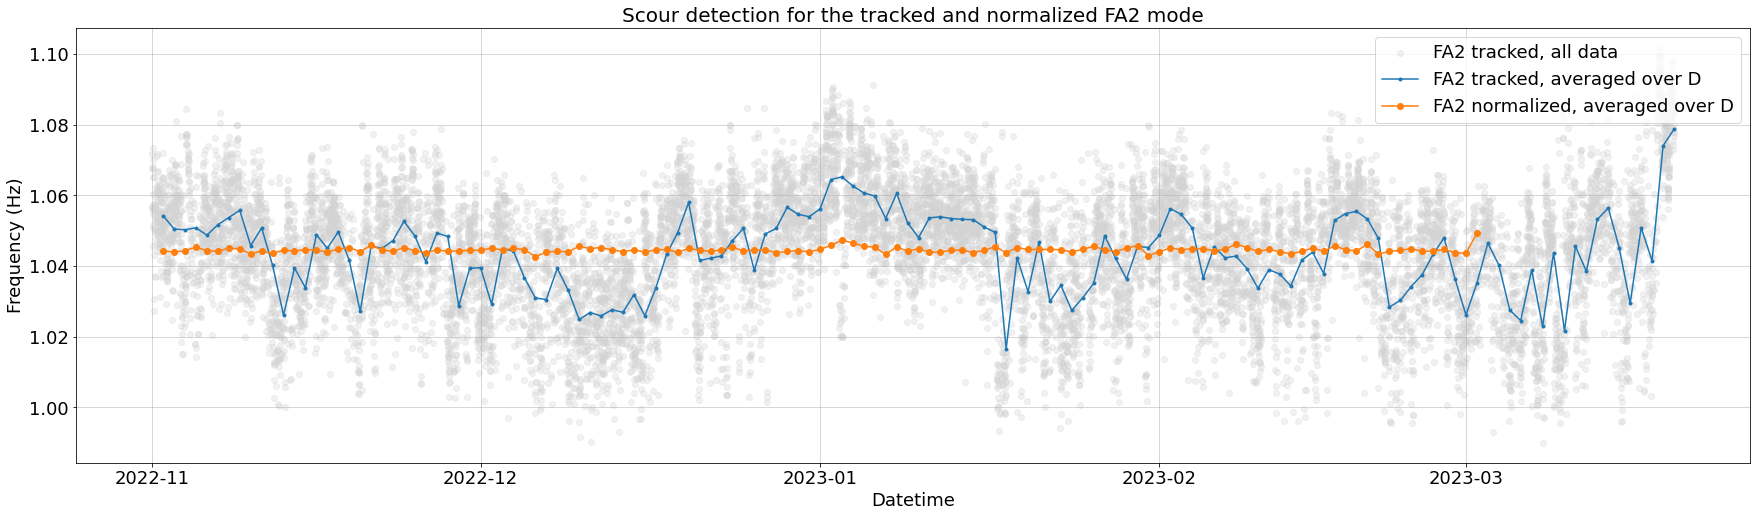

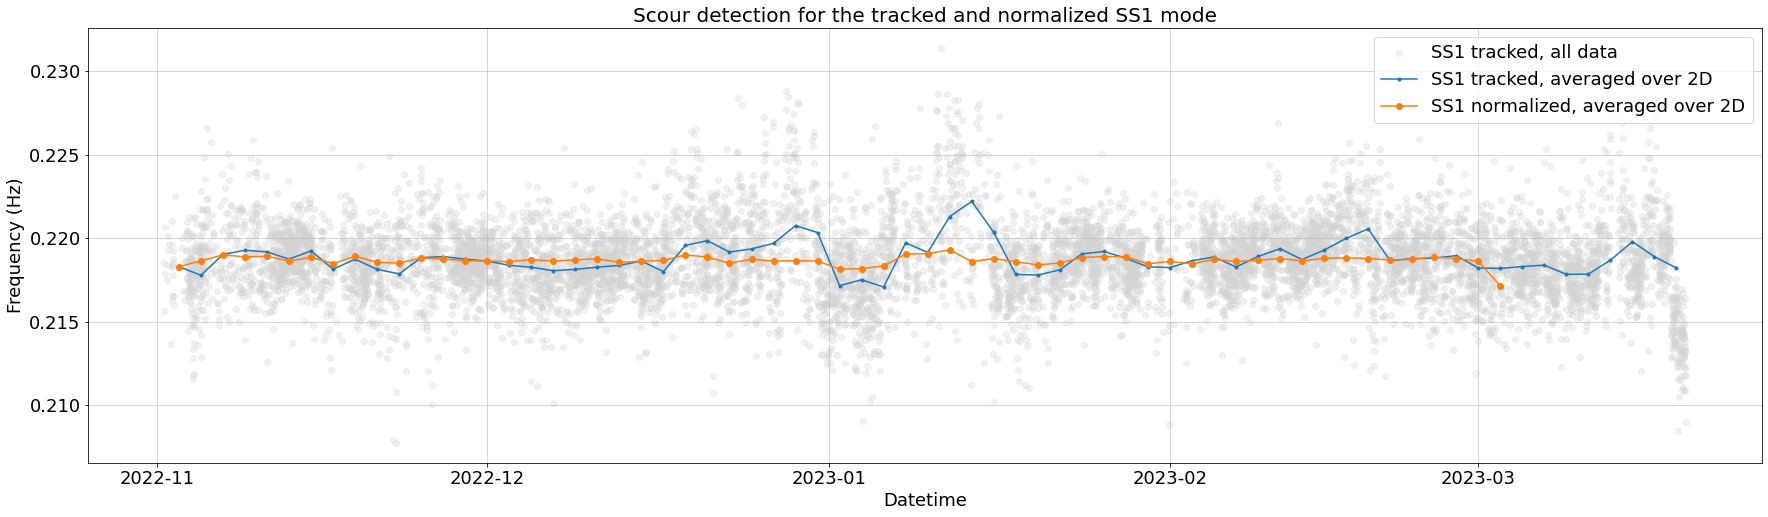

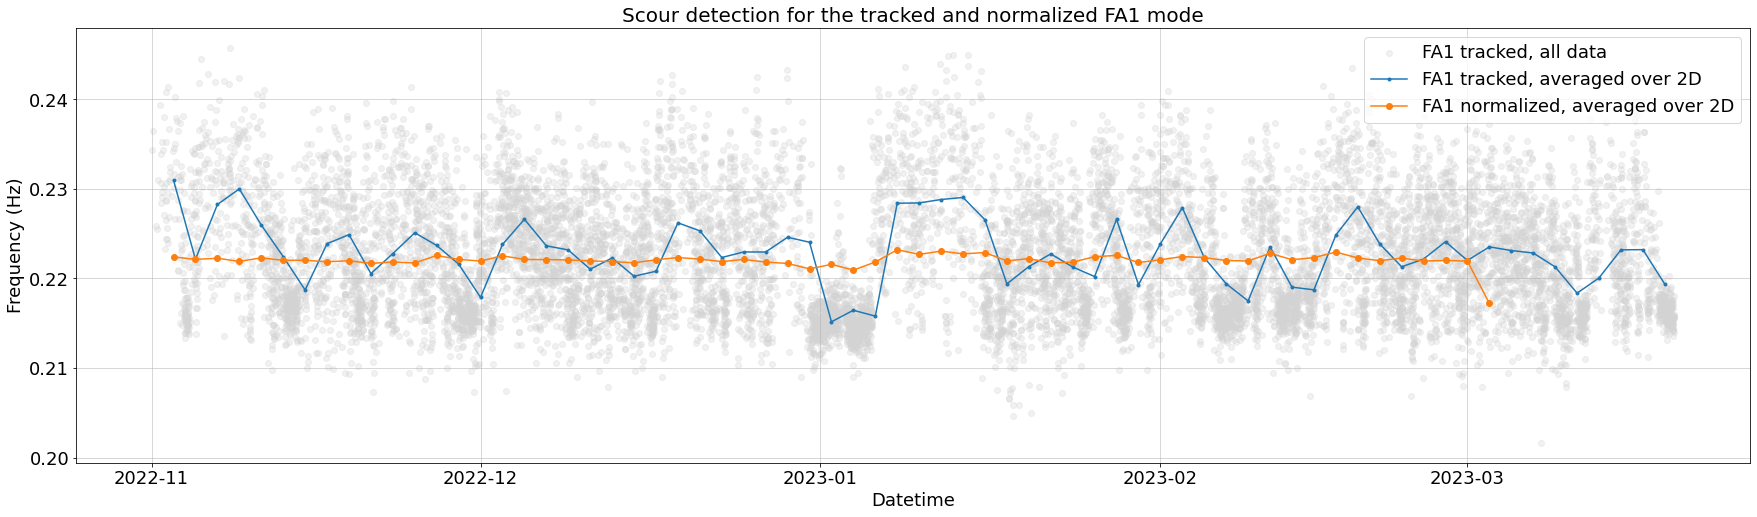

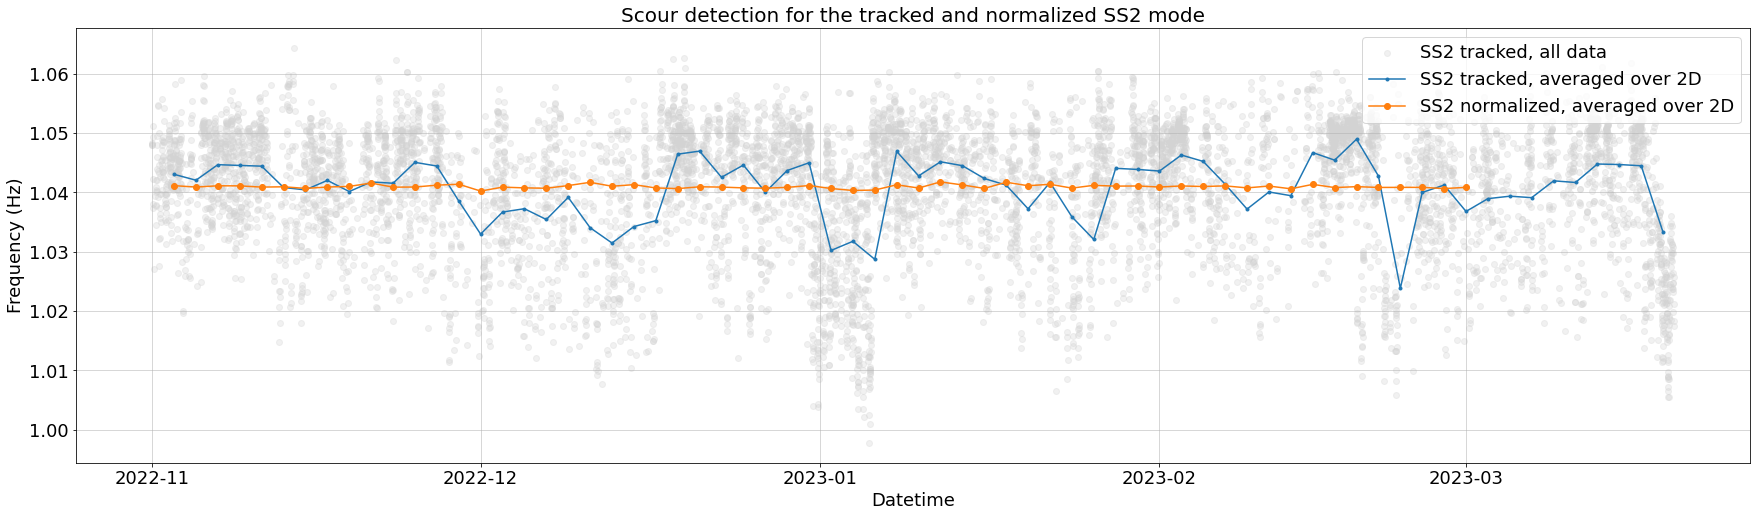

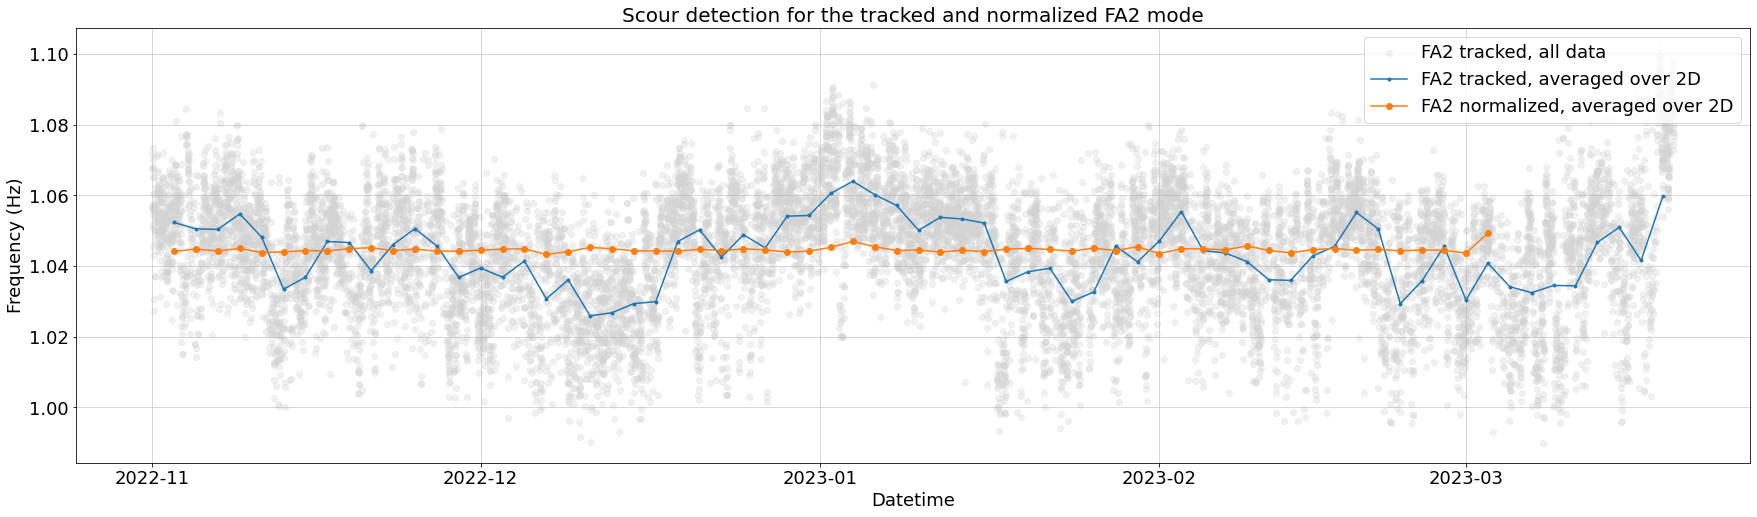

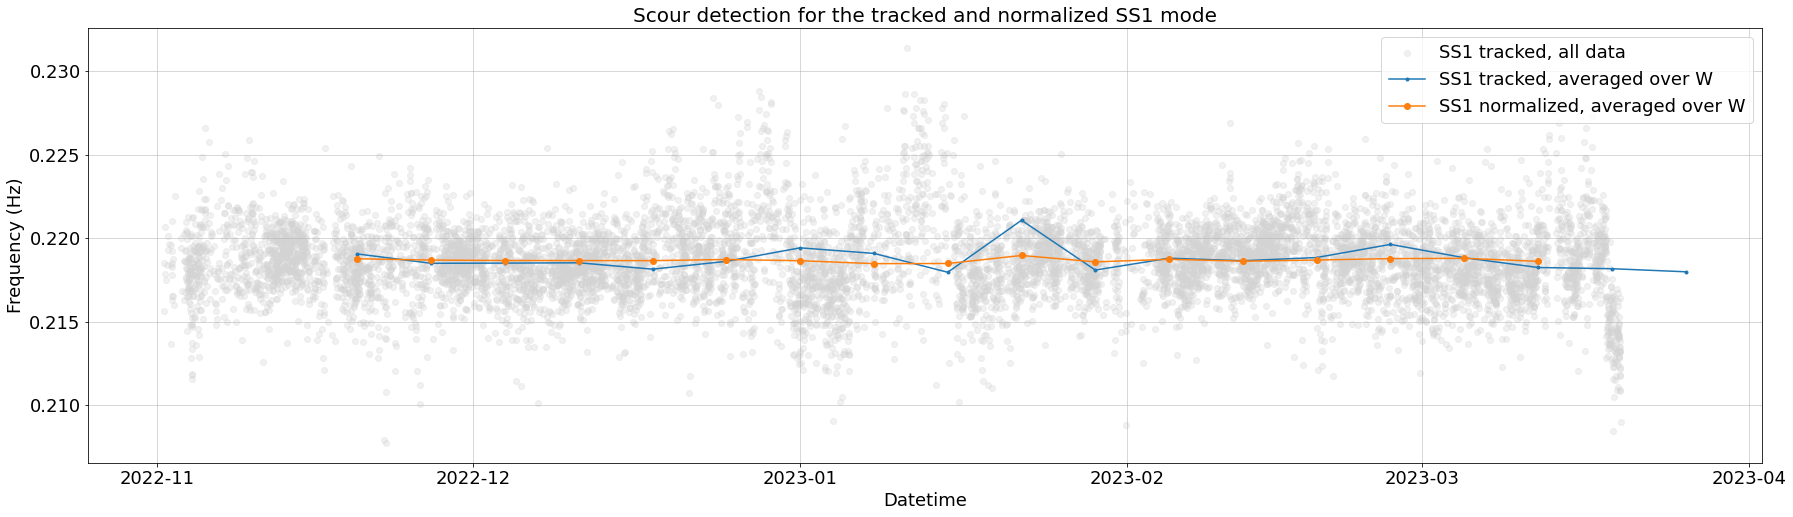

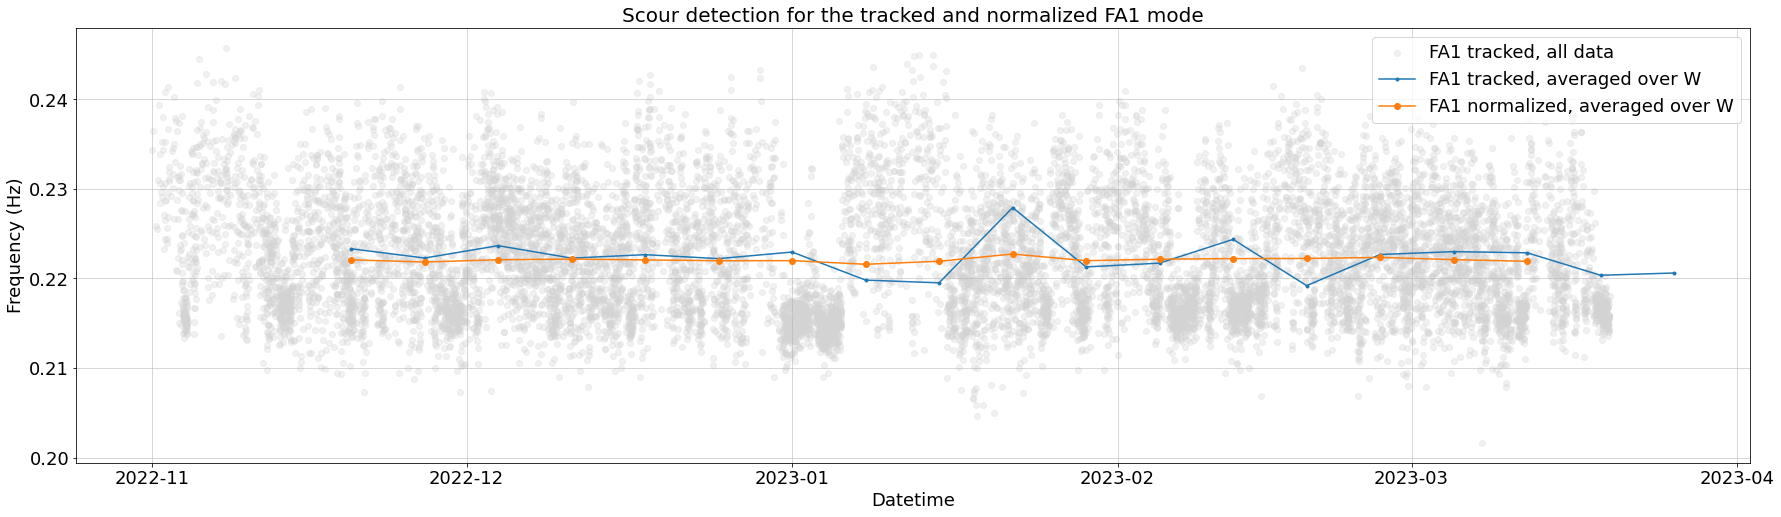

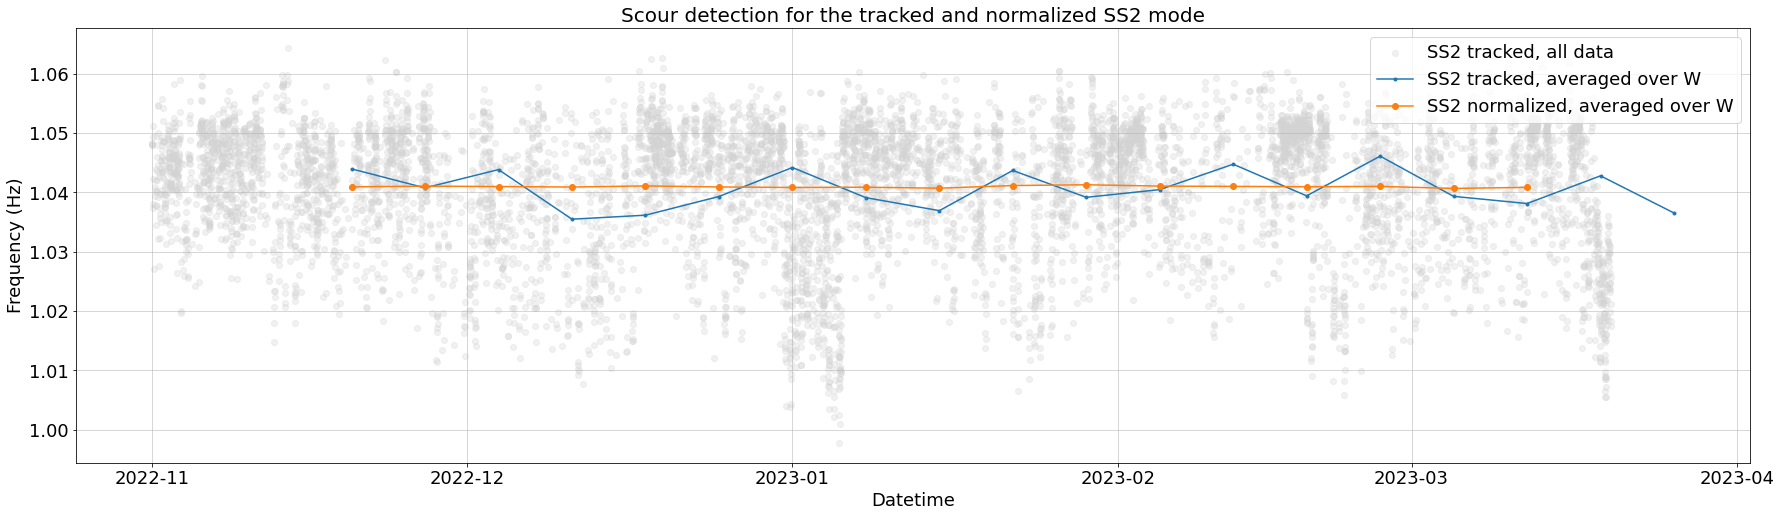

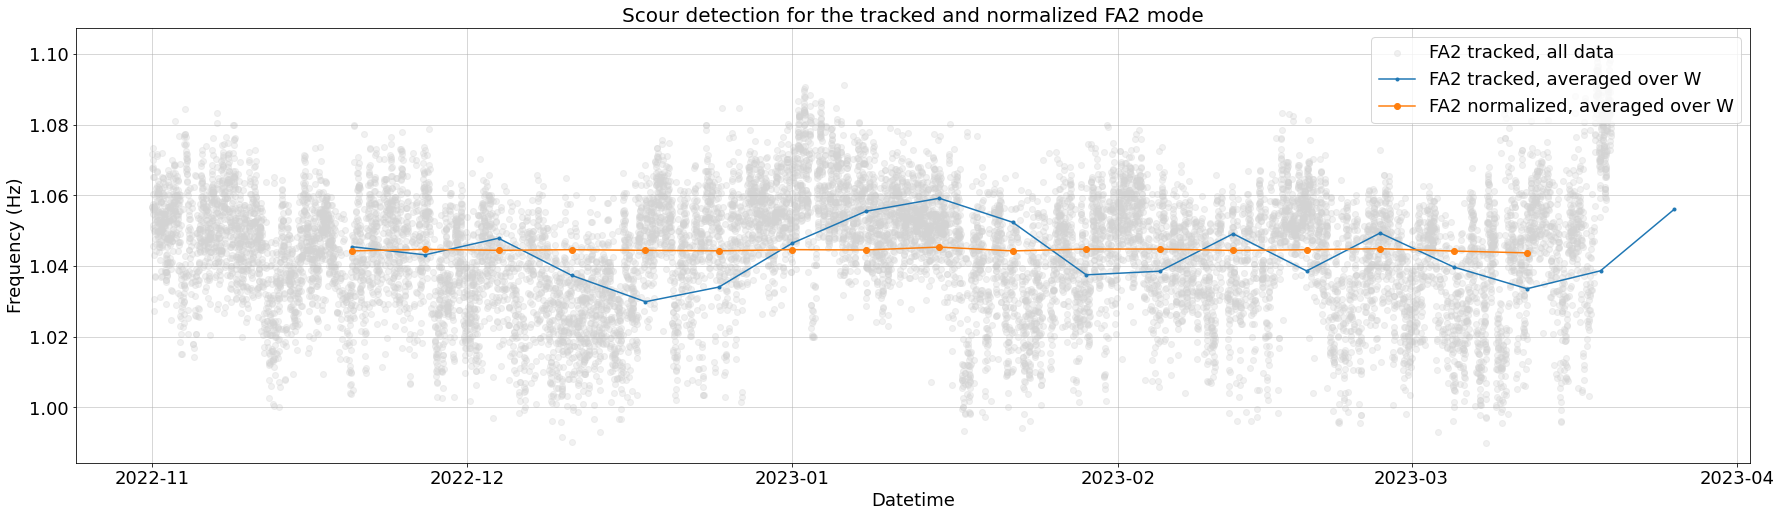

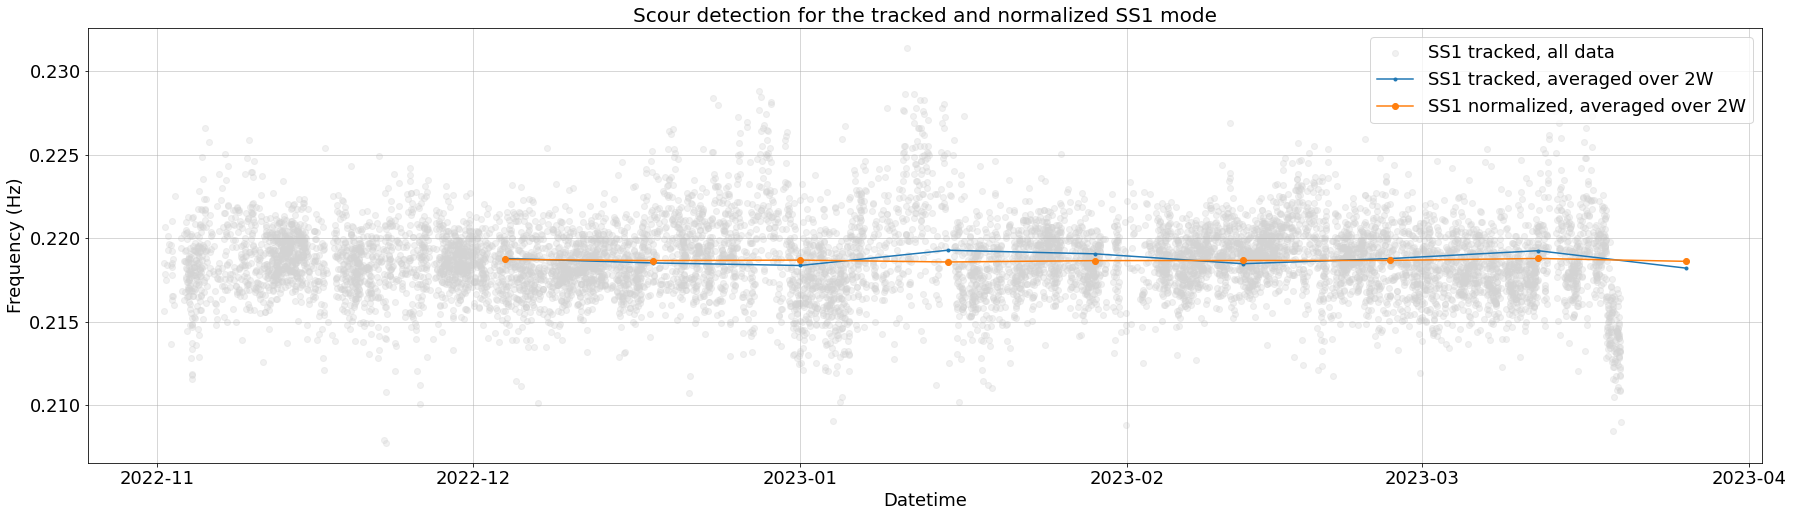

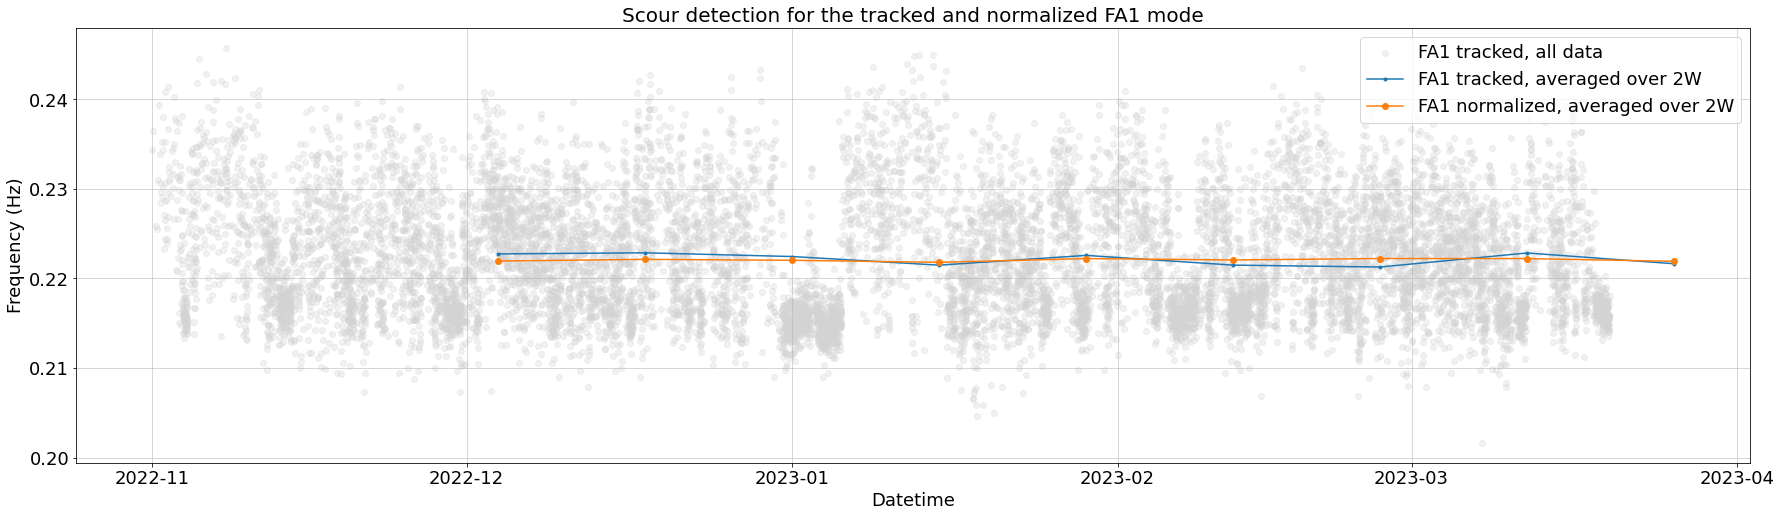

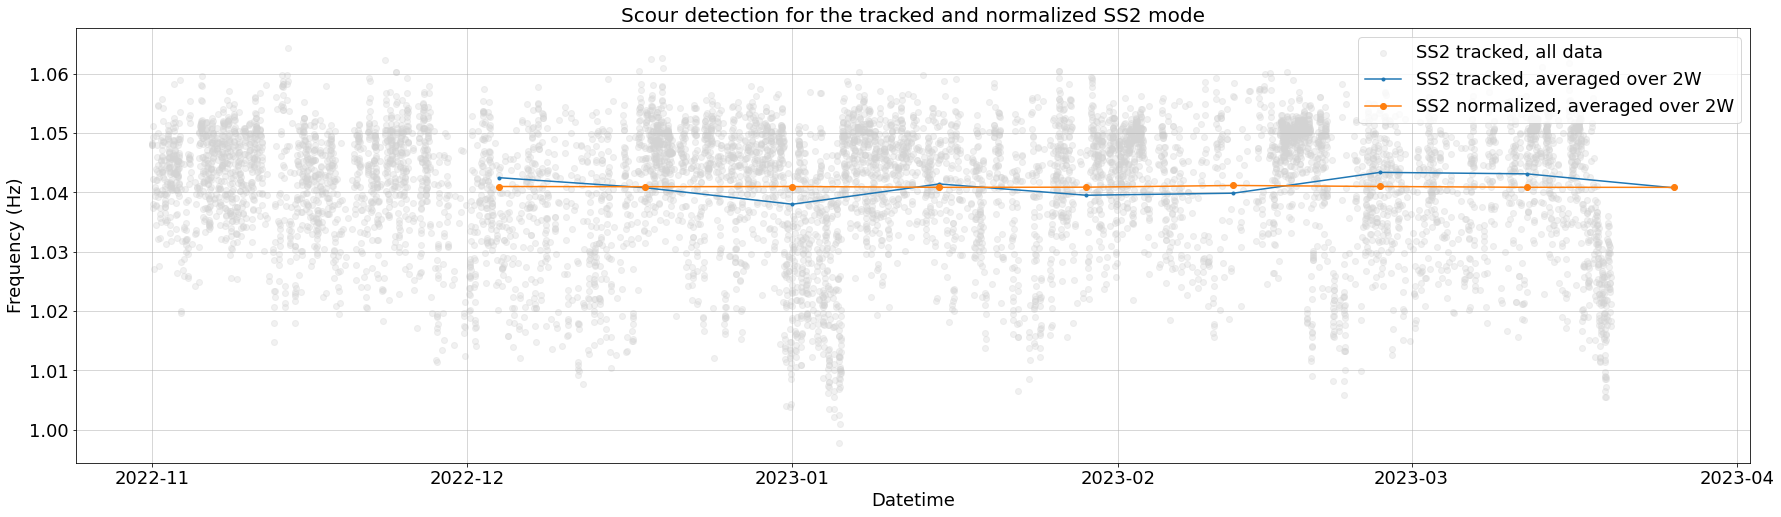

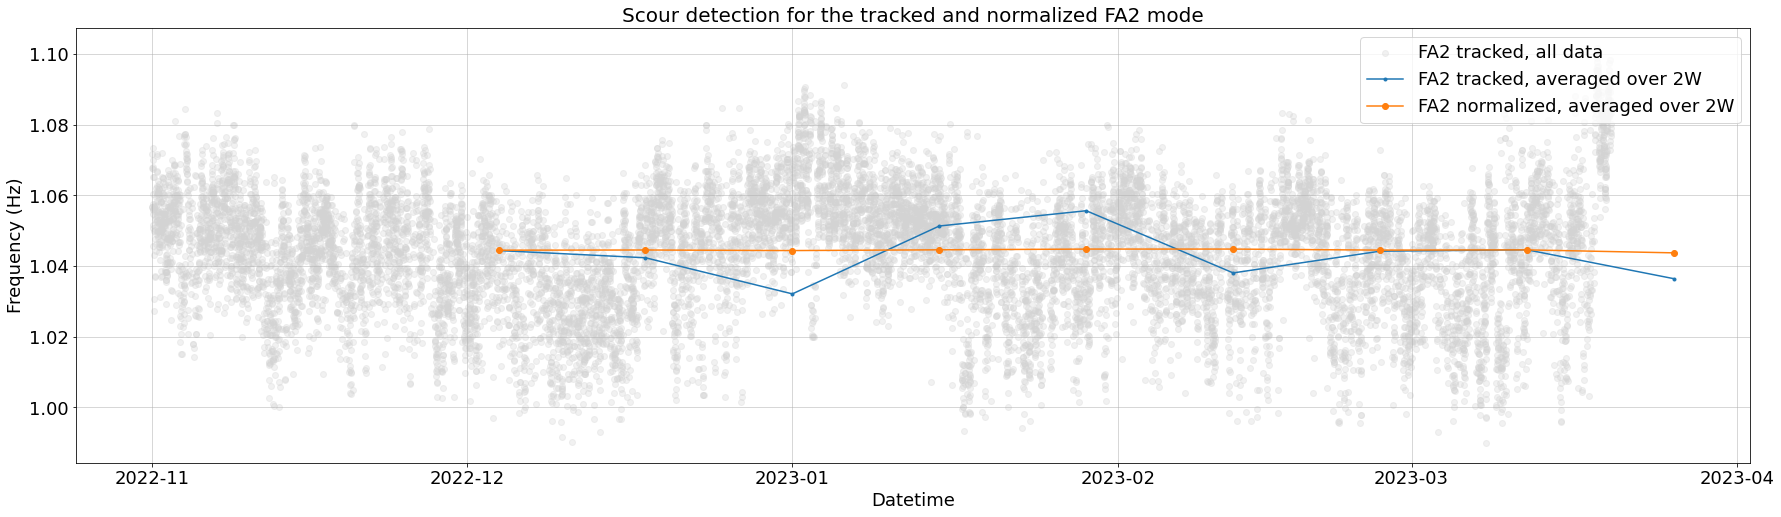

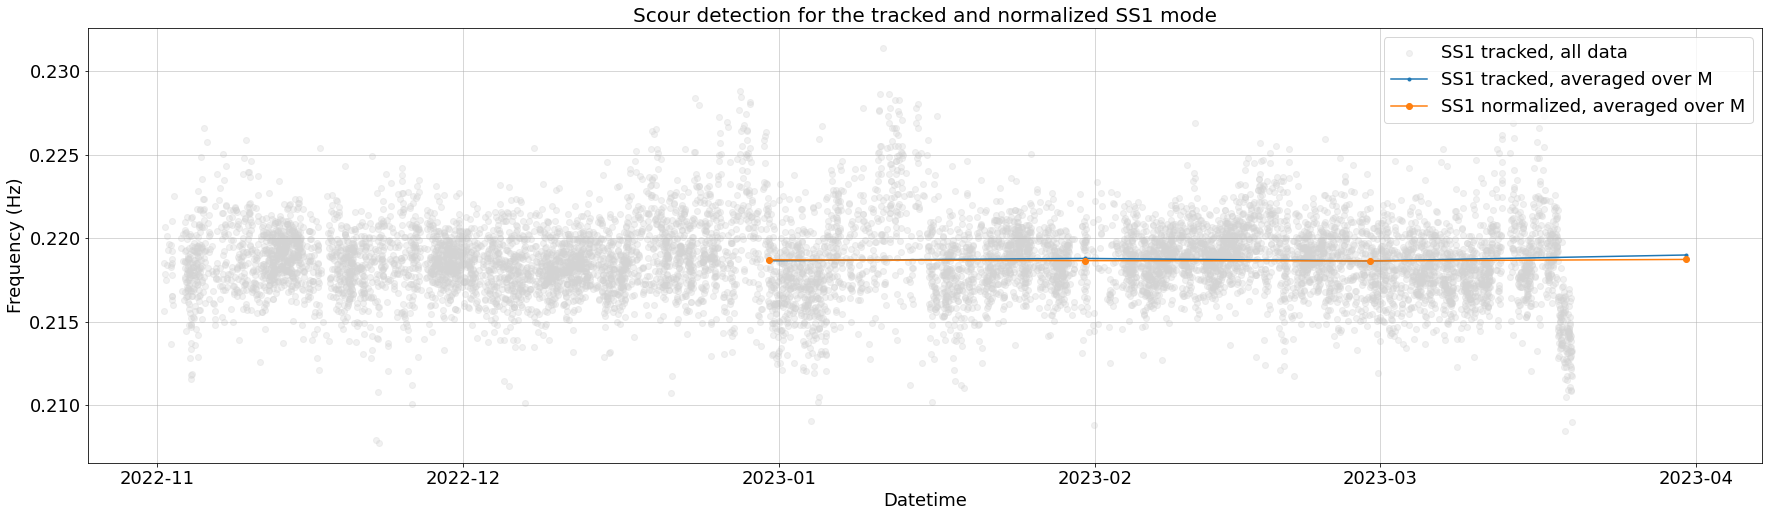

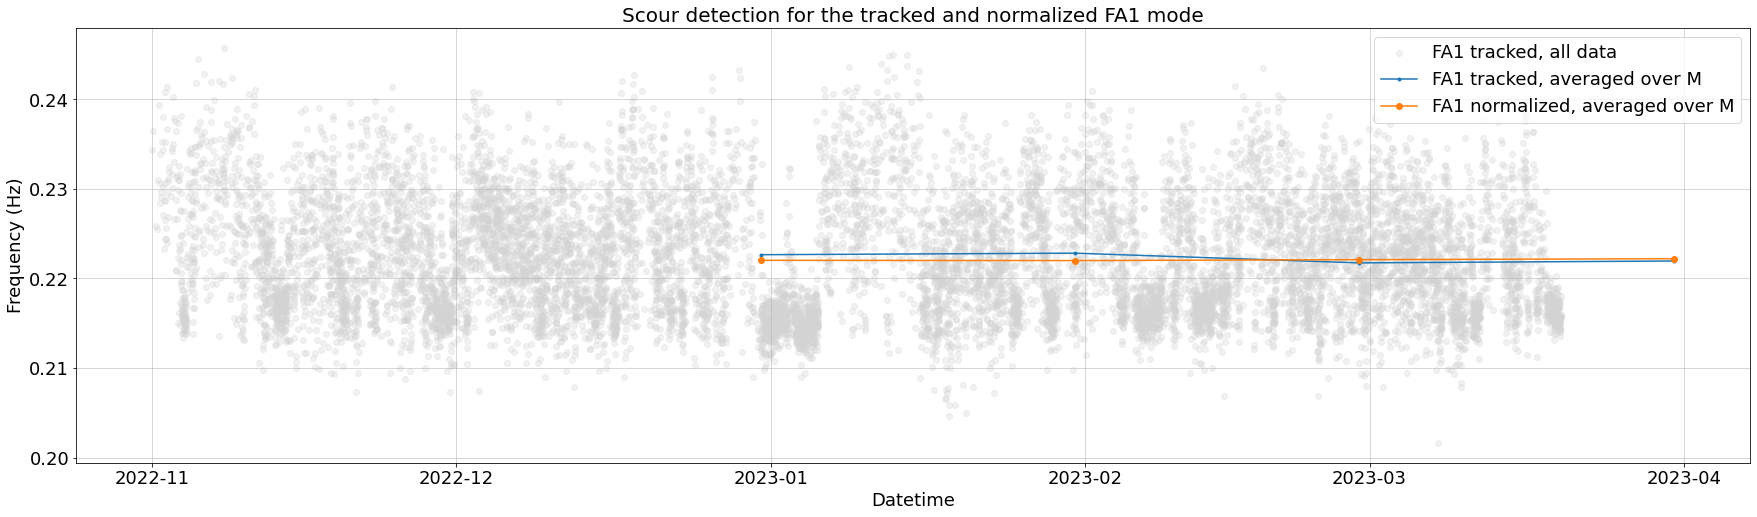

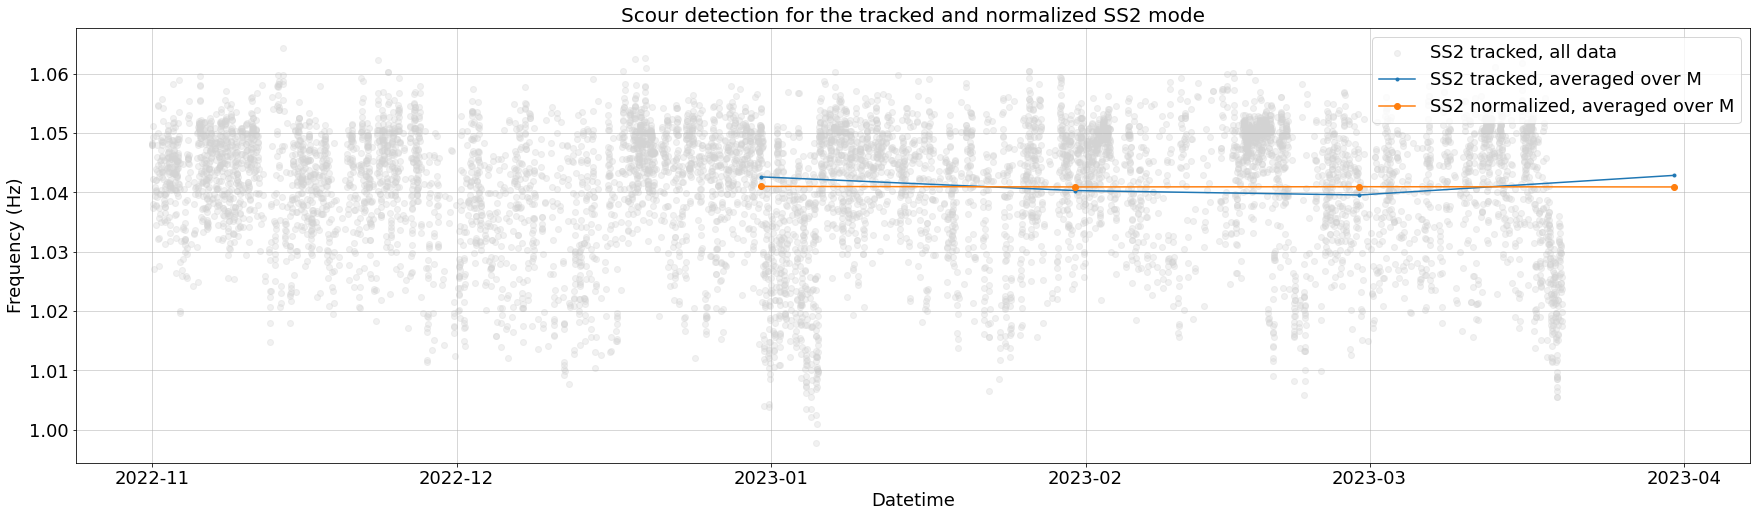

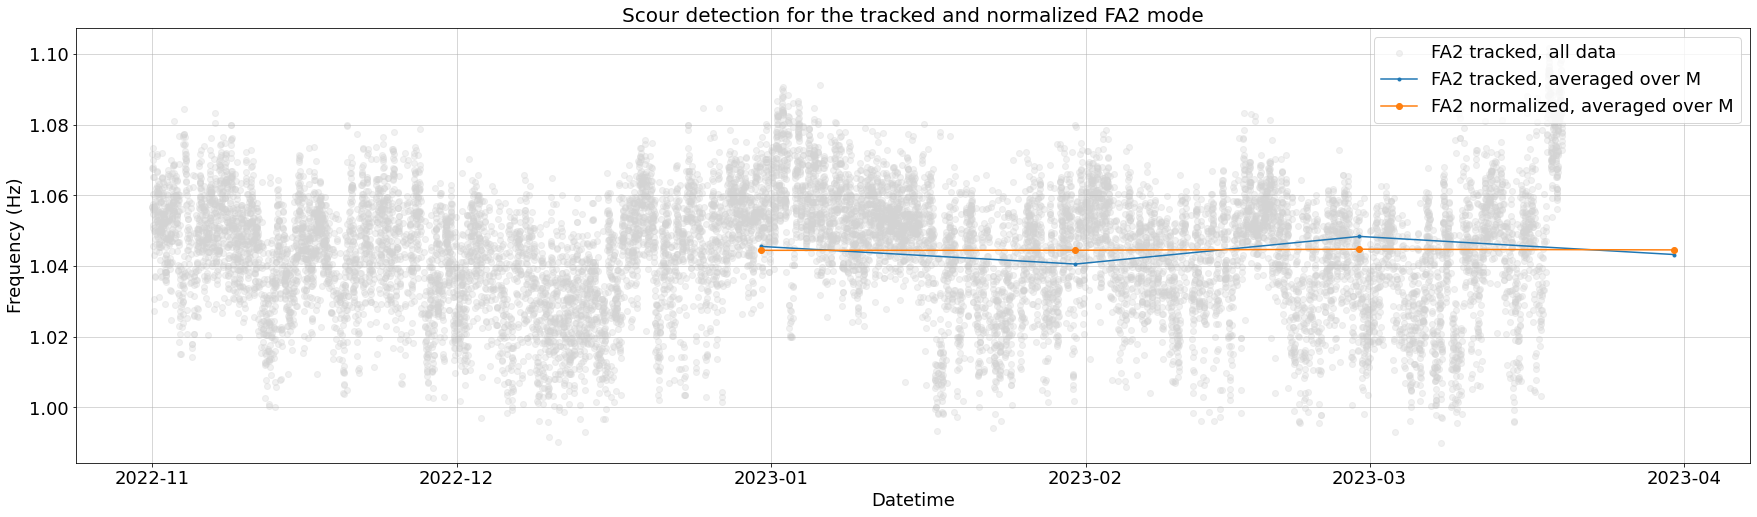

In [17]:
import warnings
warnings.filterwarnings('ignore')
font_size = 18
markers = ['.', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
timespans = ['D', '2D', 'W', '2W', 'M']
for timespan in timespans:
    for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
        plt.figure(figsize=(30,8))
        plt.grid('--', linewidth=0.5)
        plt.title('Scour detection for the tracked and normalized ' + mode + ' mode', fontsize = 20)
        m = 0
        i = 0
        
        timely_tracked_frequencies = aggregate_time_series(tracked_frequencies, timespan)
        timely_normalized_frequencies = aggregate_time_series(normalized, timespan)
        plt.scatter(tracked_frequencies[mode].index, tracked_frequencies[mode], color='lightgrey', label = mode + ' tracked, all data', alpha=0.3)
        plt.plot(timely_tracked_frequencies[mode], label = mode + ' tracked, averaged over ' + timespan, marker = markers[m])
        m += 1
        plt.plot(timely_normalized_frequencies[mode], label = mode + ' normalized, averaged over ' + timespan, marker = markers[m])
        #label = 'scouring scenarios'
        #for value in simulation_shifts['parked_scour'][mode].values[:5]:
        #    plt.axhline(normalized[mode].mean() - normalized[mode].mean()*value/100, color='red', linestyle='--', linewidth=0.5, label = label)
        #    plt.text(normalized[mode].index[0] - datetime.timedelta(days=3), normalized[mode].mean() - normalized[mode].mean()*value/100, simulation_shifts['parked_scour']['Unnamed: 0'].values[i], fontsize=font_size)
        #    i += 1
        #    label =None
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)
        plt.xlabel('Datetime', fontsize=font_size)
        plt.ylabel('Frequency (Hz)', fontsize=font_size)
        plt.legend(fontsize=font_size, loc='upper right')
        plt.show()

In [21]:
normalized

SS1       SS2  FA1       FA2
2022-11-01 00:00:00+00:00  NaN  1.040708  NaN  1.051076
2022-11-01 00:10:00+00:00  NaN       NaN  NaN  1.040130
2022-11-01 00:20:00+00:00  NaN  1.041151  NaN  1.048560
2022-11-01 00:30:00+00:00  NaN  1.041084  NaN       NaN
2022-11-01 00:40:00+00:00  NaN  1.041266  NaN  1.040001
...                        ...       ...  ...       ...
2023-03-19 23:20:00+00:00  NaN       NaN  NaN       NaN
2023-03-19 23:30:00+00:00  NaN       NaN  NaN       NaN
2023-03-19 23:40:00+00:00  NaN       NaN  NaN       NaN
2023-03-19 23:50:00+00:00  NaN       NaN  NaN       NaN
2023-03-20 00:00:00+00:00  NaN       NaN  NaN       NaN

[20017 rows x 4 columns]

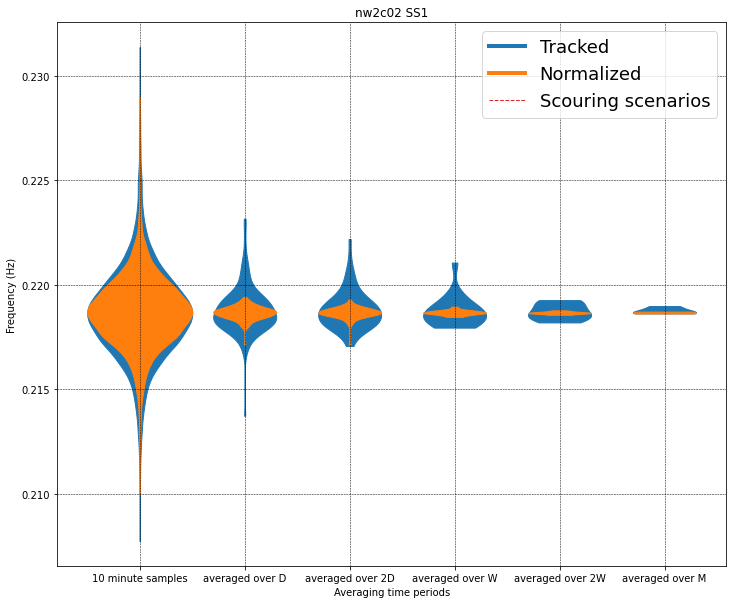

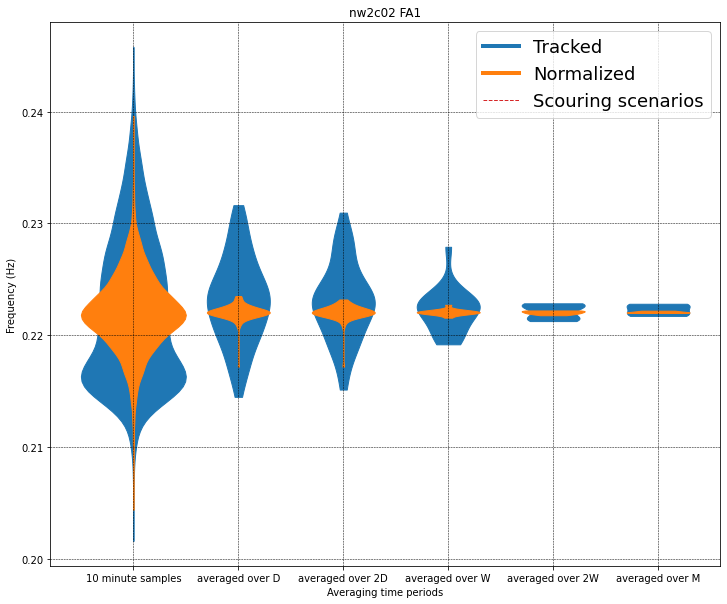

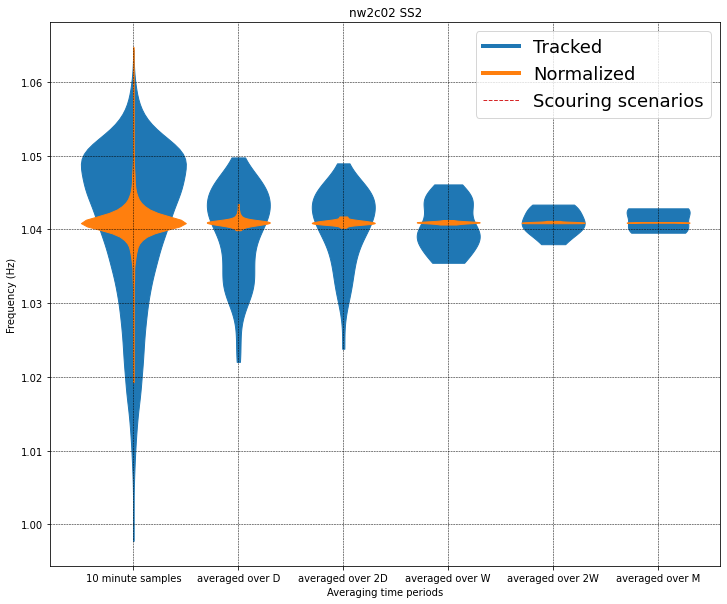

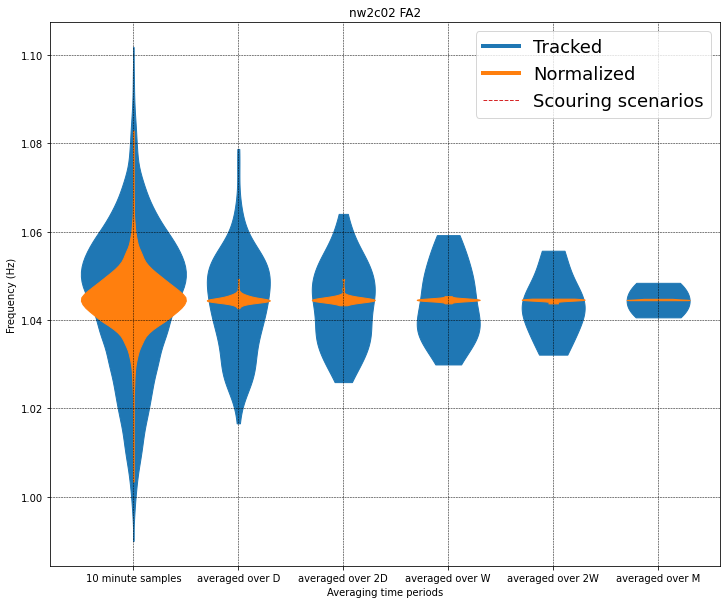

In [24]:
from matplotlib.lines import Line2D
font_size = 18
timespans = ['D', '2D', 'W', '2W', 'M']
for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
    fig, ax = plt.subplots(figsize=(12, 10))
    i = 1
    x_keys = []
    vps = plt.violinplot(tracked_frequencies[mode].dropna(), positions=[i], widths=1.0, showextrema=False)
    for vp in vps['bodies']:
        vp.set_facecolor('tab:blue')
        vp.set_color('tab:blue')
        vp.set_alpha(1)
    vps = plt.violinplot(normalized[mode].dropna(), positions=[i], widths=1.0, showextrema=False)
    for vp in vps['bodies']:
        vp.set_facecolor('tab:orange')
        vp.set_color('tab:orange')
        vp.set_alpha(1)
    
    x_keys.append('10 minute samples')
    i += 1
    for timespan in timespans:
        timely_tracked_frequencies = aggregate_time_series(tracked_frequencies, timespan)
        timely_normalized_frequencies = aggregate_time_series(normalized, timespan)
        vps = plt.violinplot(timely_tracked_frequencies[mode], positions=[i], widths=0.6, showextrema=False)
        for vp in vps['bodies']:
            vp.set_facecolor('tab:blue')
            vp.set_color('tab:blue')
            vp.set_alpha(1)
        vps = plt.violinplot(timely_normalized_frequencies[mode].dropna(), positions=[i], widths=0.6, showextrema=False)
        for vp in vps['bodies']:
            vp.set_facecolor('tab:orange')
            vp.set_color('tab:orange')
            vp.set_alpha(1)
        x_keys.append('averaged over ' + timespan)
        i += 1
    '''
    j = 0
    for value in simulation_shifts['parked_scour'][mode].values[:5]:
        shift = normalized[mode].mean() - normalized[mode].mean()*value/100
        print(shift)
        plt.axhline(shift, color='red', linestyle='--', linewidth=0.5, label = label)
        plt.text(
            0.2,
            shift,
            simulation_shifts['parked_scour']['Unnamed: 0'].values[j],
            fontsize=12
            )
        j += 1
    '''
    ax.set_xticks(range(1, len(x_keys) + 1))
    ax.set_xticklabels(x_keys, rotation=0)
    ax.set_title(location + ' ' + mode)
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Averaging time periods')
    ax.grid(True, color='k', linestyle='--', linewidth=0.5)
    plt.legend(
        [Line2D([0], [0], color='tab:blue', lw=4), Line2D([0], [0], color='tab:orange', lw=4), Line2D([0], [0], color='tab:red', lw=1, linestyle='--')],
        ['Tracked', 'Normalized', 'Scouring scenarios'],
        fontsize=font_size,
        loc='upper right')
    plt.show()